In [305]:
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from tweepy import TweepError
from textblob import TextBlob
from collections import defaultdict
from collections import Counter
from gensim import corpora, models
import numpy as np
import json
import operator
import time
import string
import pandas as pd

In [26]:
consumer_key = "xzSxeuO5GSQgZs3NwVIQrpF0S"
consumer_secret = "w4aRpCMP6sA24eZdU5HHYH2SZrPSPIgFZSTCHhSjdDN8Eusg0r"
access_token = "30304291-bQzWBtaXNBe4FG0L9Nbcq14p7WGYJjl84liBvT3YC"
access_token_secret = "WUtyRsPtsZnmDY99t7dSxnPSqDxpfwitplYzZwGBfFFPa"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [769]:
input_queries = ['Avengers','Wakanda','Marvel']
download_tweet_count = 4000 
tweetsPerQry = 200
sinceId = None
max_id = -1L

dataset = defaultdict(list)
for input_query in input_queries:
    print(input_query)
    counter = 0
    while counter < download_tweet_count:
       try:
           if (max_id <= 0):
               if (not sinceId):
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry)
               else:
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, since_id=sinceId)
           else:
               if (not sinceId):
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, max_id=str(max_id - 1))
               else:
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, max_id=str(max_id - 1), since_id=sinceId)
           for tweet in new_tweets:
               dataset['topic'].append(input_query)
               dataset['id'].append(tweet.id)
               # user related information
               dataset['username'].append(tweet.author.screen_name)
               dataset['name'].append(tweet.author.name)
               dataset['user_followers_count'].append(tweet.author.followers_count)
               dataset['user_friends_count'].append(tweet.author.friends_count)
               # tweet related information
               dataset['text'].append(tweet.text)
               dataset['created_at'].append(tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"))
               dataset['favorite_count'].append(tweet.favorite_count)
               dataset['retweet_count'].append(tweet.retweet_count)
               # some extracted data from tweet
               dataset['hashtags'].append(','.join([ht['text'] for ht in tweet.entities['hashtags']]))
               dataset['mentioned_urls'].append(','.join([url['url'] for url in tweet.entities['urls']]))
               dataset['mentioned_user_ids'].append(','.join([mention['id_str'] for mention in tweet.entities['user_mentions']]))
               dataset['mentioned_user_names'].append(','.join([mention['screen_name'] for mention in tweet.entities['user_mentions']]))
           counter +=len(new_tweets)
           max_id = new_tweets[0].id
           if counter == download_tweet_count: break
       except TweepError:
           print(len(dataset['id']))
           print('Sleeping for 15 minutes')
           time.sleep(15*60) # sleep for 15 minutes

Avengers
1258
Sleeping for 15 minutes
2015
Sleeping for 15 minutes
Wakanda
Marvel


In [932]:
file = open('Homework4Tweets.json', 'wb') 
print "Writing tweet objects to JSON please wait..."
for status in new_tweets:
    json.dump(status._json,file,sort_keys = True,indent = 4)
    
#close the file
print "Done"
file.close()

Writing tweet objects to JSON please wait...
Done


# Entire Dataset Analysis

In [846]:
#Dataframe for entire dataset
dt = pd.DataFrame.from_dict(dataset)
dt[['created_at','text','hashtags','username','user_followers_count','topic']].tail(5)

,created_at,text,hashtags,username,user_followers_count,topic
9039,2018-04-08 03:47:49,New Trailer! Wakanda is here baby! 🙅🏽‍♀️ Mar...,,MixedGirlMane,425,Marvel
9040,2018-04-08 03:21:19,RT @netheadww: Oh man... 19 days to go and the...,,DynamoCooligan,3585,Marvel
9041,2018-04-08 03:19:31,セット訪問記ソース\nhttps://t.co/xgj7cOTDTt\n\nhttps://...,,onemuseb,63,Marvel
9042,2018-04-08 03:17:23,RT @DEADLINE: ‘Infinity War’: Wakanda Takes Ce...,,dviola56,989,Marvel
9043,2018-04-08 03:03:22,RT @DEADLINE: ‘Infinity War’: Wakanda Takes Ce...,,lcm1pen,3327,Marvel


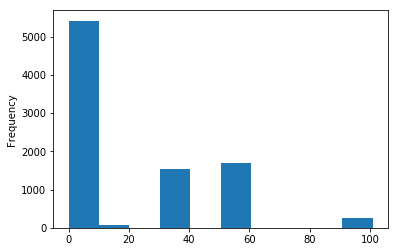

In [933]:
import matplotlib.pyplot as plt
filtered_dt = dt[dt['retweet_count'] <= np.percentile(dt['retweet_count'],99)]
filtered_dt['retweet_count'].plot.hist()
plt.show()

In [843]:
#TextBlob Sentiment Analysis - Entire Dataset

# perform sentiment analysis on each tweet
# -1 < polarity < 1 (negativity vs positivity (sentiment))
# 0 < subjectivity < 1 (factual vs opinion)
for tweet in dt['text'].head(20):
    print(tweet)
    analysis = TextBlob(tweet)
    print (analysis.sentiment)
    print("----------")

Is anyone else rewatching the Marvel movies getting ready for Avengers: Infinity Wars next week? #InfinityWars… https://t.co/7MTMvU4Z78
Sentiment(polarity=0.1, subjectivity=0.25)
----------
RT @MarvelUK: Psyched to return to Black Panther's Kingdom in Avengers: #InfinityWar? Wakanda forever! https://t.co/tDuNHDt962
Sentiment(polarity=-0.20833333333333331, subjectivity=0.43333333333333335)
----------
MARVEL MONDAY! The King is here! #BlackPanther #AvengersInfinityWar #Wakanda Forever https://t.co/sYvCVL2ZTV
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @MSTS2307: More few days to go for #AvengersInfinityWar ✨✨
#CaptainAmerica @CaptainAmerica
@Marvel @MarvelStudios @MarvelSupport #Marvel…
Sentiment(polarity=0.15, subjectivity=0.3)
----------
https://t.co/HzgJwcUkix #madeinnigeria #global #dealafriq #nigeria #ghana #senegal #africa #madeinafrica #avengers… https://t.co/TORAItpTFG
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @BoxOfficeBrief: Avengers Infinity War Givea

In [772]:
dt['SA'] = ([TextBlob(tweet).polarity for tweet in dataset['text']])
pos_tweets = [ tweet for index, tweet in enumerate(dataset['text']) if dt['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(dataset['text']) if dt['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(dataset['text']) if dt['SA'][index] < 0]

print("Senitments Breakdown - Entire Dataset:")
print("Percentage of Positive Tweets: {}%".format(len(pos_tweets)*100/len(dataset['text'])))
print("Percentage of Neutral Tweets: {}%".format(len(neu_tweets)*100/len(dataset['text'])))
print("Percentage of Negative Tweets: {}%".format(len(neg_tweets)*100/len(dataset['text'])))

Senitments Breakdown - Entire Dataset:
Percentage of Positive Tweets: 60%
Percentage of Neutral Tweets: 27%
Percentage of Negative Tweets: 11%


In [773]:
#Top 5 hashtags for entire dataset
hashtag_counter = Counter()
for hts in dt['hashtags'].values:
    hts = hts.split(',')
    hashtag_counter.update(hts)
    
sorted_cntr = sorted(hashtag_counter.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_cntr[0:5])

[('', 4428), (u'avengers', 2390), (u'BlackPanther', 1923), (u'marvel', 1917), (u'cosplay', 1466)]


# Dataset Analysis Topic #1 - "Avengers"

In [847]:
#Dataset for 'Avengers' topic
filtered_AvengersDt = dt.loc[dt['topic'] == 'Avengers']
filtered_AvengersDt[['created_at','text','hashtags','username','user_followers_count','topic']].head(2)

,created_at,text,hashtags,username,user_followers_count,topic
0,2018-04-17 01:27:09,Is anyone else rewatching the Marvel movies ge...,InfinityWars,willocassidy,29,Avengers
1,2018-04-16 23:14:49,RT @MarvelUK: Psyched to return to Black Panth...,InfinityWar,1025_marvel,805,Avengers


In [838]:
#TextBlob Sentiment Analysis - "Avengers" Dataset
for tweet in filtered_AvengersDt['text'].head(10):
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    print("----------")

Is anyone else rewatching the Marvel movies getting ready for Avengers: Infinity Wars next week? #InfinityWars… https://t.co/7MTMvU4Z78
Sentiment(polarity=0.1, subjectivity=0.25)
----------
RT @MarvelUK: Psyched to return to Black Panther's Kingdom in Avengers: #InfinityWar? Wakanda forever! https://t.co/tDuNHDt962
Sentiment(polarity=-0.20833333333333331, subjectivity=0.43333333333333335)
----------
MARVEL MONDAY! The King is here! #BlackPanther #AvengersInfinityWar #Wakanda Forever https://t.co/sYvCVL2ZTV
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @MSTS2307: More few days to go for #AvengersInfinityWar ✨✨
#CaptainAmerica @CaptainAmerica
@Marvel @MarvelStudios @MarvelSupport #Marvel…
Sentiment(polarity=0.15, subjectivity=0.3)
----------
https://t.co/HzgJwcUkix #madeinnigeria #global #dealafriq #nigeria #ghana #senegal #africa #madeinafrica #avengers… https://t.co/TORAItpTFG
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @BoxOfficeBrief: Avengers Infinity War Givea

In [810]:
filtered_AvengersDt['SA'] = ([TextBlob(tweet).polarity for tweet in filtered_AvengersDt['text']])

pos_tweets_A = [ tweet for index, tweet in enumerate(filtered_AvengersDt['text']) if filtered_AvengersDt['SA'][index] > 0]
neu_tweets_A = [ tweet for index, tweet in enumerate(filtered_AvengersDt['text']) if filtered_AvengersDt['SA'][index] == 0]
neg_tweets_A = [ tweet for index, tweet in enumerate(filtered_AvengersDt['text']) if filtered_AvengersDt['SA'][index] < 0]

print("Senitments Breakdown - Avengers Dataset:")
print("Percentage of Positive Tweets: {}%".format(len(pos_tweets_A)*100/len(filtered_AvengersDt['text'])))
print("Percentage of Neutral Tweets: {}%".format(len(neu_tweets_A)*100/len(filtered_AvengersDt['text'])))
print("Percentage of Negative Tweets: {}%".format(len(neg_tweets_A)*100/len(filtered_AvengersDt['text'])))

Senitments Breakdown - Avengers Dataset:
Percentage of Positive Tweets: 71%
Percentage of Neutral Tweets: 16%
Percentage of Negative Tweets: 12%


/Users/christinahill/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [777]:
#Top  hashtags for "Avengers" dataset
hashtag_counter = Counter()
for hts in filtered_AvengersDt['hashtags'].values:
    hts = hts.split(',')
    hashtag_counter.update(hts)
    
sorted_cntr = sorted(hashtag_counter.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_cntr[0:5])

[('', 2037), (u'avengers', 327), (u'AvengersInfinityWar', 240), (u'fanart', 214), (u'poster', 204)]


# Dataset Analysis Topic #2 - "Wakanda"

In [848]:
#Dataset for 'Wakanda' topic
filtered_WakandaDt = dt.loc[dt['topic'] == 'Wakanda']
filtered_WakandaDt[['created_at','text','hashtags','username','user_followers_count','topic']].head(2)

,created_at,text,hashtags,username,user_followers_count,topic
3000,2018-04-14 18:08:00,RT @BoxOfficeBrief: Avengers Infinity War Give...,,Filmgirl88,110,Wakanda
3001,2018-04-14 18:07:50,RT @BoxOfficeBrief: Avengers Infinity War Give...,,Thefbenews,1,Wakanda


In [839]:
#TextBlob Sentiment Analysis - "Wakanda" Dataset
for tweet in filtered_WakandaDt['text'].head(10):
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    print("----------")

RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving away 4 MORE of the new Avengers Infinity W…
Sentiment(polarity=0.25757575757575757, subjectivity=0.4696969696969697)
----------
RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving away 4 MORE of the new Avengers Infinity W…
Sentiment(polarity=0.25757575757575757, subjectivity=0.4696969696969697)
----------
RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving away 4 MORE of the new Avengers Infinity W…
Sentiment(polarity=0.25757575757575757, subjectivity=0.4696969696969697)
----------
RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving away 4 MORE of the new Avengers Infinity W…
Sentiment(polarity=0.25757575757575757, subjectivity=0.4696969696969697)
----------
RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving awa

In [814]:
filtered_WakandaDt['SA'] = ([TextBlob(tweet).polarity for tweet in filtered_WakandaDt['text']])

pos_tweets = [ tweet for index, tweet in enumerate(filtered_WakandaDt['text']) if filtered_WakandaDt['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(filtered_WakandaDt['text']) if filtered_WakandaDt['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(filtered_WakandaDt['text']) if filtered_WakandaDt['SA'][index] < 0]

/Users/christinahill/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [408]:
#Top 5 hashtags for "Wakanda" dataset
hashtag_counter = Counter()
for hts in filtered_WakandaDt['hashtags'].values:
    hts = hts.split(',')
    hashtag_counter.update(hts)
    
sorted_cntr = sorted(hashtag_counter.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_cntr[0:5])

[('', 2609), (u'BlackPanther', 1856), (u'marvel', 746), (u'InfinityWar', 709), (u'Avengers', 665)]


# Dataset Analysis Topic #3 - "Marvel"

In [849]:
#Dataset for 'Marvel' topic
filtered_MarvelDt = dt[dt['topic'] == 'Marvel']
filtered_MarvelDt[['created_at','text','hashtags','username','user_followers_count','topic']].head(2)

,created_at,text,hashtags,username,user_followers_count,topic
6033,2018-04-10 12:25:32,RT @TheDisneyBlog: Black Panther and Wakanda r...,,BeasleyDenzel,176,Marvel
6034,2018-04-10 12:11:03,Black Panther and Wakanda really show up in la...,,TheDisneyBlog,116734,Marvel


In [840]:
#TextBlob Sentiment Analysis - "Marvel" Dataset
# perform sentiment analysis on each tweet
# -1 < polarity < 1 (negativity vs positivity (sentiment))
# 0 < subjectivity < 1 (factual vs opinion)
for tweet in filtered_MarvelDt['text'].head(10):
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    print("----------")

RT @TheDisneyBlog: Black Panther and Wakanda really show up in latest TV trailer for Avengers: Infinity War. Plus O… https://t.co/Q2ouCUddpE
Sentiment(polarity=0.17777777777777778, subjectivity=0.5111111111111111)
----------
Black Panther and Wakanda really show up in latest TV trailer for Avengers: Infinity War. Plus Okoye has one of the… https://t.co/3MCN3bujz2
Sentiment(polarity=0.17777777777777778, subjectivity=0.5111111111111111)
----------
Don’t freeze. We’re just 2 months away until Black Panther and the rest of the Avengers descend upon… https://t.co/FsD6xT56Ds
Sentiment(polarity=-0.16666666666666666, subjectivity=0.43333333333333335)
----------
"Wakanda per sempre"? Thanos non sembra del loro stesso avviso. Quanto siete in fibrillazione per il nuovo cinecomi… https://t.co/pCRk61UjVT
Sentiment(polarity=0.0, subjectivity=0.0)
----------
#blackpanther  #ironman  #spiderman  #captainamerica  #thor #GuardiansOfTheGalaxy #Hulk #StarLord #Okoye #Avengers… https://t.co/dEfmCNo3Sg
Sent

In [855]:
filtered_MarvelDt['SA'] = ([TextBlob(tweet).polarity for tweet in filtered_MarvelDt['text']])
pos_tweets = [ tweet for index, tweet in enumerate(filtered_MarvelDt['text']) if filtered_MarvelDt['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(filtered_MarvelDt['text']) if filtered_MarvelDt['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(filtered_MarvelDt['text']) if filtered_MarvelDt['SA'][index] < 0]

/Users/christinahill/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [409]:
#Top 20 hashtags for "Marvel" dataset
hashtag_counter = Counter()
for hts in filtered_MarvelDt['hashtags'].values:
    hts = hts.split(',')
    hashtag_counter.update(hts)
    
sorted_cntr = sorted(hashtag_counter.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_cntr[0:5])

[(u'BlackPanther', 1820), (u'InfinityWar', 1711), ('', 1638), (u'Avengers', 815), (u'AvengersInfinityWar', 230)]


# Topic Modeling Analysis on Entire Dataset

In [803]:
# Process only the texts of tweets for entire dataset
all_docs = dt['text'].values

In [934]:
# Propose pre-processing chain to consider aspects of English language
import re
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 

In [935]:
#Word Tokenization using TweetTokenizer for entire dataset
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
print(tokenized[2])

[u'marvel', u'monday', u'the', u'king', u'is', u'here', u'blackpanther', u'avengersinfinitywar', u'wakanda', u'forever', u'httpstcosyvcvl2ztv']


In [851]:
#Stop-word Removal for entire dataset
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws_removed = []
for j,sent in enumerate(tokenized):
    sws_removed.append([i for i in sent if i not in sws])
print(sws_removed[2])

[u'marvel', u'monday', u'king', u'blackpanther', u'avengersinfinitywar', u'wakanda', u'forever', u'httpstcosyvcvl2ztv']


In [801]:
#Gensim Library
dictionary = corpora.Dictionary(sws_removed)
corpus = [dictionary.doc2bow(text) for text in sws_removed]
print(corpus[2])

[(7, 1), (16, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [93]:
#LDA Model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [94]:
#Examine Results
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.072*"photo" + 0.070*"jackfluck" + 0.066*"avengers"'), (1, u'0.066*"wakanda" + 0.049*"marvel" + 0.043*"war"'), (2, u'0.066*"\u2026" + 0.057*"avengers" + 0.055*"marvel"')]


# Effect Of Data Size

In [711]:
input_queries = ['Avengers','Wakanda','Marvel']
download_tweet_count = 8000 
tweetsPerQry = 200
sinceId = None
max_id = -1L

dataset_1 = defaultdict(list)
for input_query in input_queries:
    print(input_query)
    counter = 0
    while counter < download_tweet_count:
       try:
           if (max_id <= 0):
               if (not sinceId):
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry)
               else:
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, since_id=sinceId)
           else:
               if (not sinceId):
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, max_id=str(max_id - 1))
               else:
                   new_tweets = api.search(q=input_queries, count=tweetsPerQry, max_id=str(max_id - 1), since_id=sinceId)
           for tweet in new_tweets:
               dataset_1['topic'].append(input_query)
               dataset_1['id'].append(tweet.id)
               # user related information
               dataset_1['username'].append(tweet.author.screen_name)
               dataset_1['name'].append(tweet.author.name)
               dataset_1['user_followers_count'].append(tweet.author.followers_count)
               dataset_1['user_friends_count'].append(tweet.author.friends_count)
               # tweet related information
               dataset_1['text'].append(tweet.text)
               dataset_1['created_at'].append(tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"))
               dataset_1['favorite_count'].append(tweet.favorite_count)
               dataset_1['retweet_count'].append(tweet.retweet_count)
               # some extracted data from tweet
               dataset_1['hashtags'].append(','.join([ht['text'] for ht in tweet.entities['hashtags']]))
               dataset_1['mentioned_urls'].append(','.join([url['url'] for url in tweet.entities['urls']]))
               dataset_1['mentioned_user_ids'].append(','.join([mention['id_str'] for mention in tweet.entities['user_mentions']]))
               dataset_1['mentioned_user_names'].append(','.join([mention['screen_name'] for mention in tweet.entities['user_mentions']]))
           counter +=len(new_tweets)
           max_id = new_tweets[0].id
           if counter == download_tweet_count: break
       except TweepError:
           print(len(dataset_1['id']))
           print('Sleeping for 15 minutes')
           time.sleep(15*60) # sleep for 15 minutes

Avengers
Wakanda
6825
Sleeping for 15 minutes
Marvel


In [712]:
#Dataframe for entire dataset
dt_1 = pd.DataFrame.from_dict(dataset_1)

In [845]:
#TextBlob Sentiment Analysis - Entire Dataset
# perform sentiment analysis on each tweet
# -1 < polarity < 1 (negativity vs positivity (sentiment))
# 0 < subjectivity < 1 (factual vs opinion)
for tweet in dt_1['text'].head(20):
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    print("----------")

RT @MarvelUK: Psyched to return to Black Panther's Kingdom in Avengers: #InfinityWar? Wakanda forever! https://t.co/tDuNHDt962
Sentiment(polarity=-0.20833333333333331, subjectivity=0.43333333333333335)
----------
MARVEL MONDAY! The King is here! #BlackPanther #AvengersInfinityWar #Wakanda Forever https://t.co/sYvCVL2ZTV
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @MSTS2307: More few days to go for #AvengersInfinityWar ✨✨
#CaptainAmerica @CaptainAmerica
@Marvel @MarvelStudios @MarvelSupport #Marvel…
Sentiment(polarity=0.15, subjectivity=0.3)
----------
https://t.co/HzgJwcUkix #madeinnigeria #global #dealafriq #nigeria #ghana #senegal #africa #madeinafrica #avengers… https://t.co/TORAItpTFG
Sentiment(polarity=0.0, subjectivity=0.0)
----------
RT @BoxOfficeBrief: Avengers Infinity War Giveaway 🚨! We are launching our new channel by giving away 4 MORE of the new Avengers Infinity W…
Sentiment(polarity=0.25757575757575757, subjectivity=0.4696969696969697)
----------
RT @BoxOffic

In [714]:
dataset_1['SA'] = ([TextBlob(tweet).polarity for tweet in dataset_1['text']])

pos_tweets = [ tweet for index, tweet in enumerate(dataset_1['text']) if dataset_1['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(dataset_1['text']) if dataset_1['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(dataset_1['text']) if dataset_1['SA'][index] < 0]

print("Senitments Breakdown - Entire Dataset:")
print("Percentage of Positive Tweets: {}%".format(len(pos_tweets)*100/len(dataset_1['text'])))
print("Percentage of Neutral Tweets: {}%".format(len(neu_tweets)*100/len(dataset_1['text'])))
print("Percentage of Negative Tweets: {}%".format(len(neg_tweets)*100/len(dataset_1['text'])))

Senitments Breakdown - Entire Dataset:
Percentage of Positive Tweets: 50%
Percentage of Neutral Tweets: 40%
Percentage of Negative Tweets: 9%


In [800]:
# Process only the texts of tweets for entire dataset
all_docs_1 = dt_1['text'].values
print(all_docs[2])

MARVEL MONDAY! The King is here! #BlackPanther #AvengersInfinityWar #Wakanda Forever https://t.co/sYvCVL2ZTV


In [718]:
#Word Tokenization using TweetTokenizer for entire dataset
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs_1:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
print(tokenized[2])

[u'rt', u'msts2307', u'more', u'few', u'days', u'to', u'go', u'for', u'avengersinfinitywar', u'\u2728', u'\u2728', u'captainamerica', u'captainamerica', u'marvel', u'marvelstudios', u'marvelsupport', u'marvel', u'\u2026']


In [719]:
#Stop-word Removal for entire dataset
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws_removed = []
for j,sent in enumerate(tokenized):
    sws_removed.append([i for i in sent if i not in sws])
print(sws_removed[2])

[u'msts2307', u'days', u'go', u'avengersinfinitywar', u'\u2728', u'\u2728', u'captainamerica', u'captainamerica', u'marvel', u'marvelstudios', u'marvelsupport', u'marvel', u'\u2026']


In [799]:
#Gensim Library
dictionary = corpora.Dictionary(sws_removed)
corpus = [dictionary.doc2bow(text) for text in sws_removed]
print(corpus[2])

[(7, 1), (16, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [722]:
#LDA Model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [723]:
#Examine Results
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.078*"marvel" + 0.062*"wakanda" + 0.055*"avengers"'), (1, u'0.057*"avengers" + 0.053*"wakanda" + 0.046*"de"'), (2, u'0.047*"\ud83e" + 0.047*"\udd17" + 0.043*"avengers"')]


# Topic Model Results Without Stop Word Removal

In [945]:
all_docs = dt['text'].values

In [946]:
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
print(tokenized[2])

[u'marvel', u'monday', u'the', u'king', u'is', u'here', u'blackpanther', u'avengersinfinitywar', u'wakanda', u'forever', u'httpstcosyvcvl2ztv']


In [947]:
#Gensim Library
dictionary = corpora.Dictionary(tokenized)
corpus = [dictionary.doc2bow(text) for text in tokenized]
print(corpus[2])

[(8, 1), (9, 1), (14, 1), (19, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]


In [948]:
ldamodel = models.ldamodel.LdaModel(num_topics=3, id2word = dictionary, passes=20)

In [949]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.001*"httpstco7aua0xky6l" + 0.001*"nidlpgeek" + 0.001*"of"'), (1, u'0.001*"nouvelle" + 0.001*"blackwidow" + 0.001*"foi"'), (2, u'0.001*"httpstco67dabpjj8j" + 0.001*"you" + 0.001*"rewatching"')]


# Results With Frequent Words In Twitter Removed

In [785]:
all_docs = dt['text'].values

In [825]:
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
#print(tokenized[2])

In [787]:
#Stop-word Removal for frequent words
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws.add('wakanda')
sws.add('avengers')
sws.add('marvel')
sws_removed = []
for j,sent in enumerate(tokenized):
    sws_removed.append([i for i in sent if i not in sws])
print(sws_removed[2])

[u'monday', u'king', u'blackpanther', u'avengersinfinitywar', u'forever', u'httpstcosyvcvl2ztv']


In [826]:
dictionary = corpora.Dictionary(sws_removed)
corpus = [dictionary.doc2bow(text) for text in sws_removed]
#print(corpus[2])

In [419]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [421]:
print(ldamodel.print_topics(num_topics=3, num_words=4))

[(0, u'0.076*"\u2026" + 0.075*"blackpanther" + 0.046*"liked" + 0.046*"man"'), (1, u'0.042*"\udd17" + 0.042*"\ud83e" + 0.036*"de" + 0.033*"\ud83d"'), (2, u'0.062*"spot" + 0.044*"infinity" + 0.044*"war" + 0.041*"de"')]


# Punctutation Removal Analysis

In [794]:
all_docs = dt['text'].values

In [828]:
#Do not include punctuation removal
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens)]).split())
print(tokenized[2])

[u'marvel', u'monday', u'!', u'the', u'king', u'is', u'here', u'!', u'#blackpanther', u'#avengersinfinitywar', u'#wakanda', u'forever', u'https://t.co/syvcvl2ztv']


In [791]:
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws_removed = []
for j,sent in enumerate(tokenized):
    sws_removed.append([i for i in sent if i not in sws])
print(sws_removed[2])

[u'marvel', u'monday', u'!', u'king', u'!', u'#blackpanther', u'#avengersinfinitywar', u'#wakanda', u'forever', u'https://t.co/syvcvl2ztv']


In [829]:
dictionary = corpora.Dictionary(sws_removed)
corpus = [dictionary.doc2bow(text) for text in sws_removed]
#print(corpus[2])

In [177]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [178]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.091*":" + 0.044*"." + 0.044*","'), (1, u'0.080*"photo" + 0.078*"@jackfluck" + 0.060*"#marvel"'), (2, u'0.051*":" + 0.050*"war" + 0.050*"infinity"')]


# Word Stemming Analysis

In [793]:
all_docs = dt['text'].values

In [872]:
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
print(tokenized[2])

[u'marvel', u'monday', u'the', u'king', u'is', u'here', u'blackpanther', u'avengersinfinitywar', u'wakanda', u'forever', u'httpstcosyvcvl2ztv']


In [951]:
#Stop-word Removal for frequent words
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws_removed = []
for j,sent in enumerate(tokenized):
    sws_removed.append([i for i in sent if i not in sws])
print(sws_removed[2])

[u'marvel', u'monday', u'king', u'blackpanther', u'avengersinfinitywar', u'wakanda', u'forever', u'httpstcosyvcvl2ztv']


In [969]:
#Word-stemming
ps = PorterStemmer()
stemmed = []

for doc in all_docs: 
    sentence = word_tokenize(doc.lower())
    stems = (' '.join([ps.stem(tokenized) for tokenized in sentence]))
    stemmed.append(stems)

print(stemmed[2])

marvel monday ! the king is here ! # blackpanth # avengersinfinitywar # wakanda forev http : //t.co/syvcvl2ztv


In [973]:
dictionary = corpora.Dictionary(sws_removed)
corpus = [dictionary.doc2bow(token) for token in sws_removed]
#print(corpus[2])

In [663]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [664]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, u'0.067*"avengers" + 0.062*"\u2026" + 0.054*"marvel"'), (1, u'0.050*"wakanda" + 0.036*"avengers" + 0.036*"war"'), (2, u'0.064*"avengers" + 0.053*"wakanda" + 0.043*"de"')]
